# **Análise Exploratória de Dados de Logística**

##  Contexto

Análise de comportamento do operador logístico **Loggi** na região de Brasília. 


## Pacotes e bibliotecas

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ebac_geocoder")
from geopy.extra.rate_limiter import RateLimiter

!pip3 install geopandas;
import seaborn as sns
import pandas as pd
import geopandas

## Exploração de dados

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [32]:
# dado bruto em um dict:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)  

In [ ]:
# dado bruto no pandas:
deliveries_df = pd.DataFrame(data)

deliveries_df

In [34]:
# trabalhando na coluna "origin":
hub_origin_df = pd.json_normalize(deliveries_df["origin"])  

deliveries_df = pd.merge(left=deliveries_df,
                         right=hub_origin_df,
                         how='inner', 
                         left_index=True, 
                         right_index=True)

deliveries_df = deliveries_df.drop("origin", axis=1)

deliveries_df = deliveries_df[["name", 
                               "region",
                               "lng", 
                               "lat",
                               "vehicle_capacity",
                               "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng",
                              "lat": "hub_lat"},
                      inplace=True)

In [35]:
#trabalhando na coluna "deliveries":
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")    

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"]
               .apply(lambda record: record["size"]))
  .rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"]
               .apply(lambda record: record["point"]["lng"]))
  .rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"]
               .apply(lambda record: record["point"]["lat"]))
  .rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df,
                         right=deliveries_normalized_df,
                         how='right',
                         left_index=True,
                         right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [ ]:
# DataFrame
deliveries_df

## Manipulação

In [37]:
# Trasformando as coordenadas em endereços: 
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_geodata_df = pd.json_normalize(hub_df["geodata"]
                                   .apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[["address.town",
                                 "address.suburb",
                                 "address.city"]]

hub_geodata_df.rename(columns={"address.town": "hub_town", 
                               "address.suburb": "hub_suburb",
                               "address.city": "hub_city"},
                       inplace=True)

hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), 
                                      hub_geodata_df["hub_city"], 
                                      hub_geodata_df["hub_town"])

hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(),
                                        hub_geodata_df["hub_suburb"], 
                                        hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

In [38]:
# Combinando os DataFrames:
hub_df = pd.merge(left=hub_df, 
                  right=hub_geodata_df, 
                  left_index=True,
                  right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, 
right=hub_df, how="inner", on="region")

deliveries_df = deliveries_df[["name", 
                               "region", "hub_lng", "hub_lat",  "hub_city", 
                               "hub_suburb", "vehicle_capacity",
                               "delivery_size", "delivery_lng",
                               "delivery_lat"]]

In [39]:
# Fazendo a geocodificação reversa da entrega:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_df = pd.merge(left=deliveries_df,
                         right=deliveries_geodata_df[["delivery_city",
                         "delivery_suburb"]], how="inner", left_index=True, 
                         right_index=True)

In [ ]:
# DataFrame enriquecido
deliveries_df

In [ ]:
# controle de qualidade(coluna com tipo de dados):
deliveries_df.info()

In [ ]:
# controle de qualidade(dados faltantes):
deliveries_df.isna().any()

## Visualização

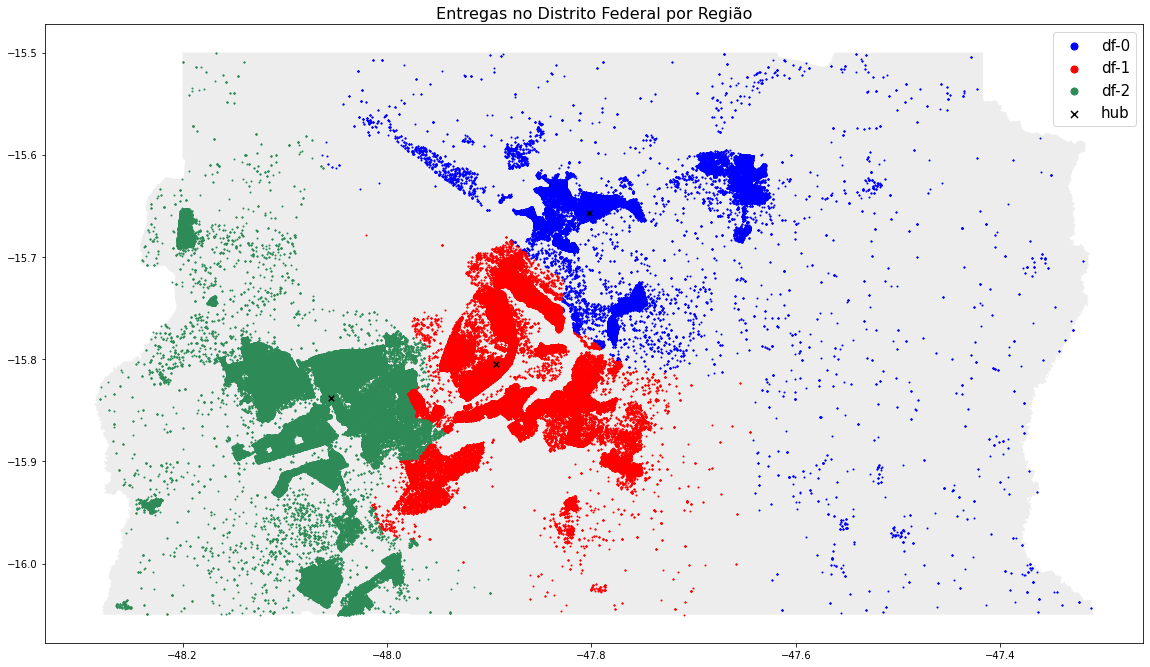

In [44]:
# Mapa da região de Brasília:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

hub_df = deliveries_df[["region","hub_lng",
"hub_lat"]].drop_duplicates().reset_index(drop=True)

geo_hub_df = geopandas.GeoDataFrame(hub_df, 
                                    geometry=geopandas.points_from_xy(hub_df["hub_lng"],
                                    hub_df["hub_lat"]))

geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df,
                                           geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"],
                                           deliveries_df["delivery_lat"]))

fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

geo_deliveries_df.query("region == 'df-0'").plot(ax=ax,
                                                 markersize=1,
                                                 color="blue",
                                                 label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1,
                                                 color="red", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax,
                                                 markersize=1, 
                                                 color="seagreen", 
                                                 label="df-2")

geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})

for handle in lgnd.legendHandles:
    handle.set_sizes([50])


**Insights**:

1.   As entregas estão corretamente alocadas aos seus respectivos hubs;

2.   Os hubs das regiões 0 e 2 fazem entregas em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

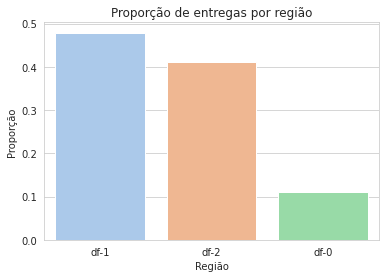

In [46]:
# Comportamento das entregas:

# Gráfico das proporções de entrega:
data = pd.DataFrame(deliveries_df[['region', 
              'vehicle_capacity']].value_counts(normalize=True)).reset_index()

data.rename(columns={0: "region_percent"}, inplace=True)

with sns.axes_style('whitegrid'):
  
  grafico = sns.barplot(data=data, x="region", y="region_percent",
                        ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região',
              xlabel='Região', ylabel='Proporção');

**Insight**:
 

*    A **distribuição das entregas** está muito concentrada nos hubs das **regiões** **df-1** e **df-2**, mas pouco no da **região df-0**.



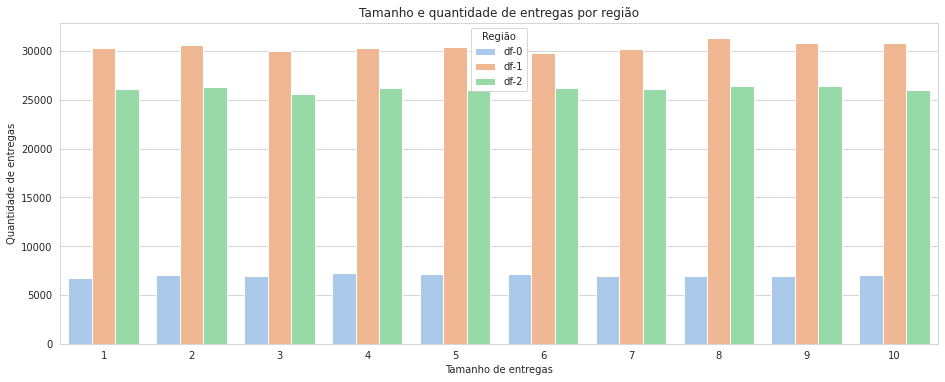

In [47]:
# Gráfico das quantidades de entrega separadas pelo tamanho e região:
delivery_region_df = deliveries_df[['region','delivery_size']]

delivery_sorted = delivery_region_df.sort_values(by=['delivery_size'],
                              ascending=False).reset_index(drop=True)

delivery_sorted_amout = pd.concat([delivery_sorted[['region','delivery_size']], 
pd.DataFrame({'amout': len(delivery_sorted)*[1]})], axis=1)

delivery_sorted_amout_df = delivery_sorted_amout.groupby(['region',
                                  'delivery_size']).agg('count').reset_index()

with sns.axes_style('whitegrid'):

  grafico = sns.barplot(data=delivery_sorted_amout_df, x='delivery_size',
                        y='amout', hue='region', ci=None,palette='pastel')
  grafico.set(title='Tamanho e quantidade de entregas por região', 
              xlabel='Tamanho de entregas',
               ylabel='Quantidade de entregas',);
  grafico.get_legend().set_title('Região');
  grafico.figure.set_size_inches(w=40/2.54, h=15/2.54)


**Insight**:

*    A **região df-0** possui **pouco volume de carga** e o **tamanho** de suas entregas **em relação aos outros hubs** é menor. 



## Resumo de insights

A distribuição das entregas está muito **concentrada** nos hubs das **regiões df-1** e **df-2**, mas **pouco** no da **região df-0**. Contudo a **capacidade dos veículos é mesma** para todos os **hubs**, logo os **veículos**  da **região df-0** poderiam ser **deslocados** para a **região df-1** pois tem o maior volume de entregas e as maiores entregas.